## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B testing is essentially an experiment where two or more variants of a page are shown to users at random, and statistical analysis is used to determine which variation performs better for a given conversion goal.
My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
# Importing Necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [3]:
df = pd.read_csv('ab_data.csv')
print(f"Number of observations in df: {df.shape}")
df.head()

Number of observations in df: (294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
print(f"Number of unique users in df: {df['user_id'].nunique()}")

Number of unique users in df: 290584


In [10]:
print(f"Proportion of users converted: {(df['converted'].sum() / len(df))*100:.4f}")

Proportion of users converted: 11.9659


- The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query("group == 'treatment' and landing_page != 'new_page'").shape[0] + df.query("group != 'treatment' and landing_page == 'new_page'").shape[0]

3893

In [13]:
print(f"Rows with Null Values:\n{df.isnull().sum()}")

Rows with Null Values:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


- For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now we will create a new dataset **df2** that meets the above specifications.

In [8]:
df.query("group == 'treatment' and landing_page != 'new_page'").shape[0] + df.query("group != 'treatment' and landing_page == 'new_page'").shape[0]

3893

In [9]:
df.query("group == 'control' and landing_page != 'old_page'").shape[0] + df.query("group != 'control' and landing_page == 'old_page'").shape[0]

3893

In [14]:
print(f"Number of observations before removing: {df.shape}")
df.drop(df.query("group == 'treatment' and landing_page != 'new_page'").index, axis = 0,inplace = True)
df.drop(df.query("group != 'treatment' and landing_page == 'new_page'").index, axis = 0,inplace = True)
df.drop(df.query("group == 'control' and landing_page != 'old_page'").index, axis= 0,inplace = True)
df.drop(df.query("group != 'control' and landing_page == 'old_page'").index,axis = 0,inplace = True)
print(f"Number of observations after removing: {df.shape}")

Number of observations before removing: (294478, 5)
Number of observations after removing: (290585, 5)


In [16]:
#create copy of dataframe
df2 = df.copy()

In [17]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [18]:
print(f"Number of unique userd_ids in df2: {df2['user_id'].nunique()}")

Number of unique userd_ids in df2: 290584


In [23]:
print('Duplicated row:')
df2[df2['user_id'].duplicated()]

Duplicated row:


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [24]:
#Remove row with duplicate user_id
df2.drop(labels = 2893,axis = 0,inplace = True)

In [25]:
print(f"Number of observation after removing duplicate row: {df2.shape}")

Number of observation after removing duplicate row: (290584, 5)


a. What is the probability of an individual converting regardless of the page they receive?

In [26]:
print(f"Probability of an individual converting regardless of the page they receive:{df2['converted'].sum() / df2.shape[0]:.4f}")

Probability of an individual converting regardless of the page they receive:0.1196


b. Given that an individual was in the `control` group, what is the probability they converted?

In [28]:
control = df2.query("group == 'control'")
print(f"Probability of an individual converting if in control group:{control['converted'].sum() / control.shape[0]:.4f}")

Probability of an individual converting if in control group:0.1204


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [30]:
treatment = df2.query("group == 'treatment'")
print(f"Probability of an individual converting if in treatment group:{treatment['converted'].sum() / treatment.shape[0]:.4f}")

Probability of an individual converting if in treatment group:0.1188


In [32]:
obs_diff = treatment['converted'].sum() / treatment.shape[0] - control['converted'].sum() / control.shape[0]
print(f"Difference between the probability of control and treatment group: {obs_diff:.4f}")

Difference between the probability of control and treatment group: -0.0016


>- **Negative difference between treatment & control group do suggest us that conversion rate of treament group is less than control group.**

d. What is the probability that an individual received the new page?

In [42]:
print('Probabilty that individual received the new page:',df2.query("landing_page == 'new_page'").shape[0]/ df2.shape[0])

Probabilty that individual received the new page: 0.5000619442226688


`Conclusion`:
- **We haven't yet find any evidence to claim that new treatment page leads to more conversion.To reach our result we should dive in more using hypothesis testing & regression model. **

<a id='ab_test'></a>
### Part II - A/B Test

`Setting Hypothesis`:

`Null Hypothesis`: conversion on new page **$p_{new}$** would be less or equal to the old page **$p_{old}$**.

`Alternative Hypothesis`: Conversion on new page **$p_{new}$** is higher than old page **$p_{old}$**.

> ##  **H0** : **$p_{new}$** <= **$p_{old}$**

> ##  **H1** : **$p_{new}$** > **$p_{old}$**

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [43]:
pnew=df2['converted'].mean()
print(f"Convert rate for new page:{pnew:.4f}")

Convert rate for new page:0.1196


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [45]:
pold=df2['converted'].mean()
print(f"Convert rate for old page:{pold:.4f}")

Convert rate for old page:0.1196


c. What is $n_{new}$?

In [46]:
n_new=df2.query("landing_page =='new_page'").shape[0]
print(f"Number of users landing on new page: {n_new}")

Number of users landing on new page: 145310


d. What is $n_{old}$?

In [47]:
n_old=df2.query("landing_page =='old_page'").shape[0]
print(f"Number of users landing on old page: {n_old}")

Number of users landing on old page: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [48]:
new_page_converted=np.random.binomial(n=1,p=pnew,size = n_new)
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [49]:
old_page_converted = np.random.binomial(n = 1,p = pold, size =n_old )
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [50]:
pnew-pold


0.0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [51]:
p_diffs = []
for _ in range(10000):
    boot_new_page_converted = np.random.binomial(n = 1,p = pnew,size = n_new)
    boot_old_page_converted = np.random.binomial(n = 1,p = pold,size = n_old )
    p_diffs.append(boot_new_page_converted.mean() - boot_old_page_converted.mean())

In [52]:
p_diffs = np.array(p_diffs)


i. Plot a histogram of the **p_diffs**.  

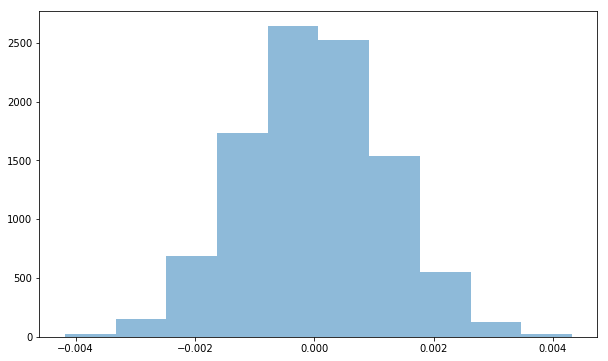

In [55]:
plt.figure(figsize = (10,6))
plt.hist(p_diffs,alpha = 0.5);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [57]:
print(f"Proportion of p_diffs are greater than the actual difference: {(p_diffs>obs_diff).mean()}")

Proportion of p_diffs are greater than the actual difference: 0.9047


**`Results:`**

The probability we got is 0.9069 which is far above the alpha rate of 5%. This Suggest that we have failed to reject the null & there is no suffiecient evidence to say that there is difference between the two values.

**`Comparison to built in z-test`**

In [61]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()
print(f"Number of users converted for an old page: {convert_old}\nNumber of users converted for a new page: {convert_new}")

Number of users converted for an old page: 17489
Number of users converted for a new page: 17264


In [62]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative = 'larger')

In [66]:
print(f"Z score:{z_score:.6f}\nP value:{p_value:.6f}")

Z score:1.310924
P value:0.094942


In [67]:
from scipy.stats import norm

norm.cdf(z_score)
# Tells us how significant our z-score is

norm.ppf(1-(0.05/2))
# Tells us what our critical value at 95% confidence is

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**`Results`**: 

Critical Value is larger than Z-score which again suggest us that we have failed to reject the null & there is no suffiecient evidence to say that there is difference between the two values.

<a id='regression'></a>
### Part III - A regression approach

**Logistic Regression**

first we need to create a column for the intercept, and create a dummy variable column for which page each user received. 

In [76]:
df2['intercept'] = 1
df2[['control','ab_page']]= pd.get_dummies(df2['group'])

In [78]:
df2.drop(labels = 'control',axis = 1, inplace= True)

In [79]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**Instantiate and fit the model** 

In [80]:
lg=sm.Logit(df2['converted'], df2[['intercept', 'ab_page' ]])
results = lg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 19 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:40:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

- The p-value (0.190) here remains above an $\alpha$ level of 0.05 but is different from p-value observed in bootstrap approach because this is a two tailed test. We will still reject the null in this situation.

Add an additional variable to the model

Additional information regarding conversion rates is available for user country. The model is tested to see if there is an interaction between the country of the user and the conversion rates between the old and new pages.

In [85]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [83]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [84]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [86]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])

In [87]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [88]:
log_mod=sm.Logit(df_new['converted'], df_new[['intercept','CA','UK']])
results_mod = log_mod.fit()
results_mod.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 19 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        13:45:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**Probability of 0.129 Suggest that:**

- There is no statistical significant evidence that rate of conversion of an individual from CA differs from rate of conversion of an individual from US.

**Probability of 0.456 Suggest that:**

- There is no statistical significant evidence that rate of conversion of an individual from UK differs from  rate of conversion of an individual from US.


Check for an interaction 

In [89]:
df_new['ab_page_US'] = df_new['ab_page'] * df_new['US']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']

In [90]:
### Fit Your Linear Model And Obtain the Results
sm_model = sm.Logit(df_new['converted'] , df_new[['intercept','ab_page_UK','ab_page_CA','CA','UK','ab_page']])
results_model=sm_model.fit()
results_model.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 19 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        13:49:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
==============================================================================
"""

**`Results`:**

None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page
